## INTRODUCTION

The effectiveness of an e-commerce website is largely dependent on the quality and design of its web pages. In order to optimize the user experience and increase sales, it is essential to continuously monitor and improve the design and layout of these pages. In this A/B testing project, our goal was to determine whether new page designs were more effective in increasing user engagement and conversion rates than the existing page designs.

## What is A/B testing?

A/B testing, also known as split testing, refers to a randomized experimentation process wherein two or more versions of a variable (web page, page element, etc.) are shown to different segments of website visitors at the same time to determine which version leaves the maximum impact and drives business metrics.


Essentially, A/B testing eliminates all the guesswork out of website optimization and enables experience optimizers to make data-backed decisions. In A/B testing, A refers to ‘control’ or the original testing variable. Whereas B refers to ‘variation’ or a new version of the original testing variable. 

The version that moves your business metric(s) in the positive direction is known as the ‘winner.’ Implementing the changes of this winning variation on your tested page(s) / element(s) can help optimize your website and increase business ROI. 

The metrics for conversion are unique to each website. For instance, in the case of eCommerce, it may be the sale of the products. Meanwhile, for B2B, it may be the generation of qualified leads. 

A/B testing is one of the components of the overarching process of Conversion Rate Optimization (CRO), using which you can gather both qualitative and quantitative user insights. You can further use this collected data to understand user behavior, engagement rate, pain points, and even satisfaction with website features, including new features, revamped page sections, etc. If you’re not A/B testing your website, you’re surely losing out on a lot of potential business revenue.



## About the Data

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

### Part 1 : Understanding the data

To get started let's import the libraries , load the data and understand it

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # basic visualization
import seaborn as sns # advanced visualization

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Loading the Data and displaying it

df = pd.read_csv("/home/kali/Projects/AB_testing/Data/Raw/ab_test.csv")

df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [3]:
# Changing the column names for our convince

df.columns = ["user_id", "timestamp", "group", "landing_page", "converted"]

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [4]:
# Understanding the data

df.shape

(294478, 5)

In [5]:
df.nunique()

user_id         290584
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

In [6]:
# The proportion of users converted
 
df['converted'].value_counts()[1] / (df['converted'].value_counts()[0] + df['converted'].value_counts()[1]) 

0.11965919355605512

In [7]:
# The number of times the new_page and the 'treatment' don't line up

df.query("group == 'treatment' and landing_page != 'new_page'").count()[0] + \
df.query("group != 'treatment' and landing_page == 'new_page'").count()[0]    
    

3893

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [9]:
# Regroup with the new variables

df.drop(df.query("group == 'treatment' and landing_page != 'new_page'").index, inplace =True)
df.drop(df.query("group != 'treatment' and landing_page == 'new_page'").index, inplace = True)

df2 = df
df2.shape

(290585, 5)

In [10]:
# Check wether all the correct rows were removed

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# unique user_ids in df2
df2.user_id.nunique()

290584

In [12]:
# find the duplicated rows

df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0


In [13]:
duplicate = df2[df2["user_id"].duplicated()]

In [14]:
# drop the duplicated row

df2.drop(duplicate.index, inplace = True)

In [15]:
# checking is the row dropped

len(df2) - df2.user_id.nunique()

0

In [16]:
# Probability

df2[df2['converted'] == 1].count()[4] / df2['converted'].count()

0.11959708724499628

In [17]:
# The probability converted in the control group

control = df2.query("group == 'control' and converted == 1").count()[4] / df2[df2['group'] == 'control'].count()[4]
control

0.1203863045004612

In [18]:
# The probability convened in the treatment group

treatment = df2.query("group == 'treatment' and converted == 1").count()[4] / df2[df2['group'] == 'treatment'].count()[4]
treatment

0.11880806551510564

In [19]:
# The probability received in the new page

df2.query("landing_page == 'new_page'").count()[3] / df2['landing_page'].count()



0.5000619442226688

### This experiment design is  robust and persuasive with following reasons.

* From above results there are at least 50% of users willing to land on new page
* Although 11.96% of users is converted to new version
* In addition, the probability of an individual received a new page in either control or treatment group are around 12% which means not only the size of both are similar but the conversion rate are close

### Part 2 : A/B testing

Hypothesis testing :

H0 :  pold  -  pnew   >=0 

H1 :  pold  -  pnew   <0

In [20]:
# Create the sampling distribution of different in means

means_diff = []
size = df.shape [0]
for _ in range(10000):
    sample = df2.sample(size, replace = True)
    control_mean = sample[sample["group"] == "control"]["converted"].mean()
    treat_mean = sample[sample["group"] == "treatment"]["converted"].mean()
    means_diff.append(treat_mean - control_mean)

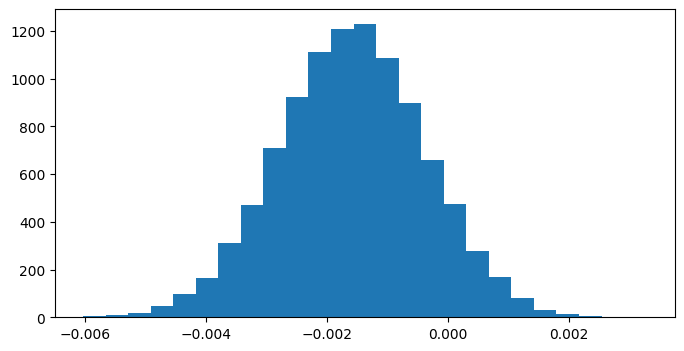

In [21]:
# Plotting the sampling distribution 

plt.figure(figsize = (8,4), dpi = 100)
plt.hist(means_diff, bins = 25)
plt.show()

In [22]:
# Simulate distribution under the hypothesis

means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)

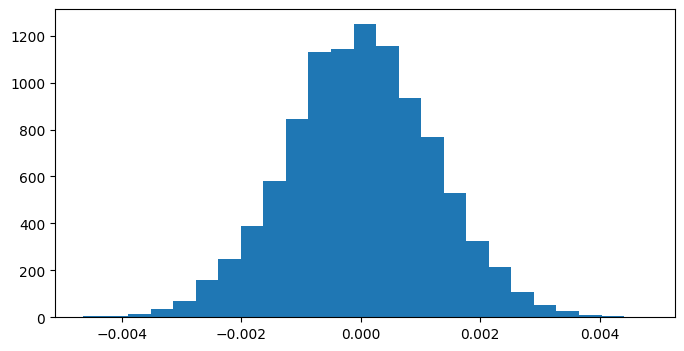

In [23]:
# plot the Null distribution

plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.show()

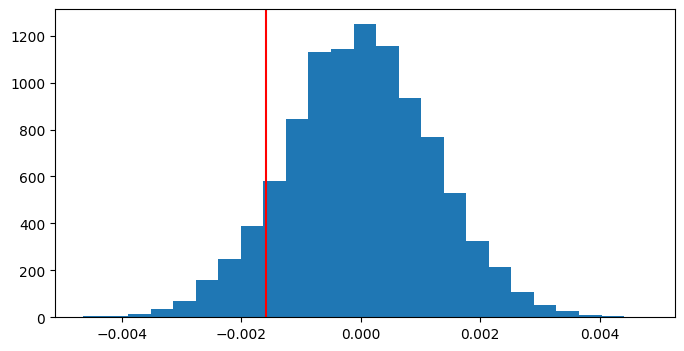

In [24]:
# Plot observed statistic with the null distribution

control_mean = df2[df2["group"] == "control"]["converted"].mean()
treat_mean = df2[df2["group"] == "treatment"]["converted"].mean()
obs_diff = treat_mean - control_mean

plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.axvline(obs_diff, c = 'red')

plt.show()

In [25]:
# Calculate the p value

(null_vals > obs_diff).mean()

0.9009

* The p-value is 9.6 which is higher than Type 1 error which is 5% therefore we should fail to reject the null(H0). Besides we can tell that actual p-value of the control group is higher than the treatment group during the calculation.
* In other words the older version  has the higher p-value than the new one, so we keep the old version and do not change to new version.

#### We can also use builtin functions to achieve similar results

In [26]:
# Applying A/B testing with statical package

import statsmodels.api as sm

convert_old = df2[(df2["converted"] == 1) & (df2["landing_page"] == "old_page")]['user_id'].nunique()
convert_new = df2[(df2["converted"] == 1) & (df2["landing_page"] == "new_page")]['user_id'].nunique()
n_old = df2[df["landing_page"] == "old_page"]['user_id'].nunique()
n_new = df2[df["landing_page"] == "new_page"]['user_id'].nunique()


In [27]:
# compute test statistic and p-value

z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]), np.array([n_new,n_old]), alternative = 'larger')

In [28]:
# print Z score and P value

z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

Using test statistic and p-value, we reach the same coclusion: we can not reject the null

## Part 3 : Regression Approach

Using Logistic Regression in this cause because the response variable are Categorical

In [33]:
# Logistic Regression approach

df2['intercept'] = 1

df2 = df2.join(pd.get_dummies(df2['landing_page']))
df2['ab_page'] = pd.get_dummies(df2['group']) ['treatment']

In [34]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,11:48.6,control,old_page,0,1,0,1,0
1,804228,01:45.2,control,old_page,0,1,0,1,0
2,661590,55:06.2,treatment,new_page,0,1,1,0,1
3,853541,28:03.1,treatment,new_page,0,1,1,0,1
4,864975,52:26.2,control,old_page,1,1,0,1,0


In [35]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

In [36]:
# Logistic regression model

result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:               8.077e-06
Time:                        12:19:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

### Findings :

* The p-value associated with 'ab_page' is 0.19 , it is different from the value in part 2 The reason is because here we want to know the 'ab_page' this attribute is significant not and it is not significant in this case
* The null is that there is no difference between the treatment and the control group . The alternative is that there is difference between treatment and control group
* The result will be stronger and more convincing with new variables added in to the regression model such as 'timestamp' moreover the result will be stronger and more conventing with new variables added such as 'timestamp' specifically we can classify this factors in to morning,after noon and evening . Also i can classify them as weekday and weekend for better performance.
* On the other hand , it will make regression model more complex and we need to check it to see if variables are dependable with each other , if yes  we need to add high order term to get the better prediction result . Otherwise the result should be trustworthy.

In [86]:
# Modeling with countries data

countries_df = pd.read_csv('/home/kali/Projects/AB_testing/Data/Raw/countries_ab.csv')
countries_df.head()


,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [88]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [89]:
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop(['CA'], axis =1)

In [90]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,UK,US
user_id,,,,,,,,,,,
834778,UK,08:43.3,control,old_page,0,1,0,1,0,1,0
928468,US,44:16.4,treatment,new_page,0,1,1,0,1,0,1
822059,UK,04:14.7,treatment,new_page,1,1,1,0,1,1,0
711597,UK,14:24.8,control,old_page,0,1,0,1,0,1,0
710616,UK,14:44.0,treatment,new_page,0,1,1,0,1,1,0


In [92]:
# Logistic Regression model

df_new['intercept'] = 1

logit2 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK','US']])
result = logit2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:               2.323e-05
Time:                        15:15:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [1]:
# calculate the exponential

1/np.exp(-0.0149), np.exp(0.560), np.exp(0.048)

NameError: name 'np' is not defined

### Findings :

* From the above we can tell that the new _page decrease one unit the converted rate will increase  1.5%
* When UK increase one unit the converted rate will increase 5.2%
* When US increase pn unit the converted rate will increase 4.2%


In [94]:
# Testing with more factors

df_new['UK_new_page'] = df_new['new_page']*df_new['UK']
df_new['US_new_page'] = df_new['new_page']*df_new['US']

In [95]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,UK,US,UK_new_page,US_new_page
user_id,,,,,,,,,,,,,
834778,UK,08:43.3,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,44:16.4,treatment,new_page,0,1,1,0,1,0,1,0,1
822059,UK,04:14.7,treatment,new_page,1,1,1,0,1,1,0,1,0
711597,UK,14:24.8,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,14:44.0,treatment,new_page,0,1,1,0,1,1,0,1,0


In [96]:
#Logistic Regression model

logit3 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK_new_page','US_new_page','UK','US']])
result = logit3.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:               3.482e-05
Time:                        16:40:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_new_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_new_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK              0.0118      0.040      0.296      0.767      -0.066       0.090
US              0.0175      0.038      0.465      0.642      -0.056       0.091
===============================================================================
"""

In [97]:
1/np.exp(-0.0674),np.exp(0.0783),np.exp(0.0469),np.exp(0.0118),np.exp(0.0175)

(1.0697232819209153,
 1.0814470441230692,
 1.048017202119183,
 1.011869894648401,
 1.0176540221507617)

### Findings:
* From above, we can tell that except the p-value of 'intercept' is less than TypeI error = 5%, other variables are exceed TypeI error = 5% which means they are not significant. In addition, their z-scores are not large enough which means they are not significant as well.
* However, we still can tell that when 'new_page' decreases one unit, the converted will increase 7%.
* When 'UK_new_page' increases one unit, the converted will increase 8.1%.
* When 'US_new_page' increases one unit, the converted will increase 4.8%.
* When 'UK' increases one unit, the converted will increase 1.2%.
* When 'US' increases one unit, the converted will increase 1.8%.

### Summary:
In this notebook we conducted a detailed A/B testing using 3 main methods:

* Sampling distribution
* Z test
* Logestic regression

All three methods resulted in the same conclusion: the treatment has no impact.